--- ASSUMPTION CHECKS ---

[Assumption 1] Outliers (IQR Method):
  - No significant outliers.

[Assumption 2] Normality (Shapiro-Wilk, p > .05):
  - PASSED. (Min p-value: 0.254)

[Assumption 3] Homogeneity (Levene, p > .05):
  - PASSED. (p=0.873)

       TWO-WAY ANOVA RESULTS
                           sum_sq    df         F    PR(>F)    eta_sq
C(Treatment)               28.275   3.0  3.788945  0.019678  0.262109
C(AD_Status)                3.025   1.0  1.216080  0.278356  0.036611
C(Treatment):C(AD_Status)   9.075   3.0  1.216080  0.319771  0.102340
Residual                   79.600  32.0       NaN       NaN  0.500000

       POST-HOC ANALYSIS (TUKEY HSD)
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 1 + 1  1 + 2      2.2 0.3752 -1.0312 5.4312  False
 1 + 1  2 + 1      2.6 0.1906 -0.6312 5.8312  False
 1 + 1  2 + 2      2.6 0.1906 -0.6312 5.8312  False
 1 + 1  3 + 1      2.0 

<Figure size 1000x600 with 0 Axes>

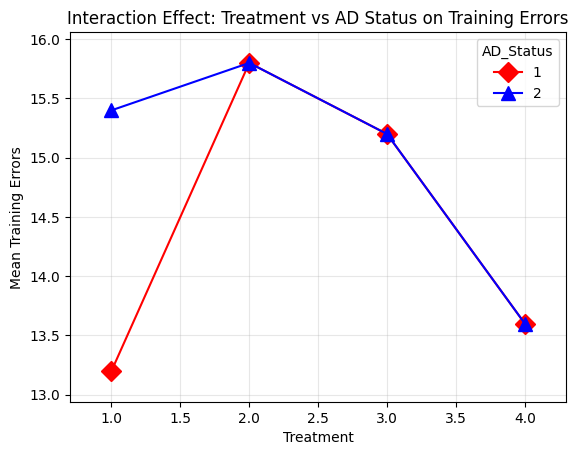

In [2]:
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/Users/imee/Downloads/Alzheimers Mice Data.csv')

print("--- ASSUMPTION CHECKS ---")

print("\n[Assumption 1] Outliers (IQR Method):")
outliers_found = False
for (t, a), g in df.groupby(['Treatment', 'AD_Status']):
    q1, q3 = g['Training'].quantile([0.25, 0.75])
    iqr = q3 - q1
    outliers = g[(g['Training'] < (q1 - 1.5*iqr)) | (g['Training'] > (q3 + 1.5*iqr))]
    if not outliers.empty:
        outliers_found = True
        print(f"  - Found in Treatment {t} / AD {a}: {outliers['Training'].values}")
if not outliers_found: 
    print("  - No significant outliers.")

print("\n[Assumption 2] Normality (Shapiro-Wilk, p > .05):")
norm_p_vals = [stats.shapiro(g['Training'])[1] for n, g in df.groupby(['Treatment', 'AD_Status'])]
if all(p > 0.05 for p in norm_p_vals):
    print(f"  - PASSED. (Min p-value: {min(norm_p_vals):.3f})")
else:
    print(f"  - FAILED for some groups. (Min p-value: {min(norm_p_vals):.3f})")

print("\n[Assumption 3] Homogeneity (Levene, p > .05):")
groups = [g['Training'].values for n, g in df.groupby(['Treatment', 'AD_Status'])]
stat, p = stats.levene(*groups)
print(f"  - {'PASSED' if p > 0.05 else 'FAILED'}. (p={p:.3f})")

print("\n" + "="*40)
print("       TWO-WAY ANOVA RESULTS")
print("="*40)


model = ols('Training ~ C(Treatment) + C(AD_Status) + C(Treatment):C(AD_Status)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

anova_table['eta_sq'] = anova_table['sum_sq'] / (anova_table['sum_sq'] + anova_table.loc['Residual', 'sum_sq'])
print(anova_table[['sum_sq', 'df', 'F', 'PR(>F)', 'eta_sq']])

print("\n" + "="*40)
print("       POST-HOC ANALYSIS (TUKEY HSD)")
print("="*40)

df['Group'] = df['Treatment'].astype(str) + " + " + df['AD_Status'].astype(str)
tukey = pairwise_tukeyhsd(endog=df['Training'], groups=df['Group'], alpha=0.05)

print(tukey.summary())

plt.figure(figsize=(10, 6))
interaction_plot(x=df['Treatment'].astype('category'), 
                 trace=df['AD_Status'].astype('category'), 
                 response=df['Training'],
                 colors=['red', 'blue'], markers=['D', '^'], ms=10)
plt.title('Interaction Effect: Treatment vs AD Status on Training Errors')
plt.ylabel('Mean Training Errors')
plt.xlabel('Treatment')
plt.grid(True, alpha=0.3)
plt.show()